<a href="https://colab.research.google.com/github/ChrisMath26/AAyCD/blob/main/Clasificacion_RL/preseleccion_de_modelo_Logit_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-2d47b31af1aa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CONSUMADO'] = np.where(df['CLASIFICACION_DE_LA_CONDUCTA'] == 'Suicidio consumado', 1, 0)
<ipython-input-2-2d47b31af1aa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PSIQUIATRIA'] = df['PSIQUIATRIA'].replace({'no': 'NO', 'si': 'SI', 'No': 'NO', 'Si': 'SI'})
<ipython-input-2-2d47b31af1aa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

    Modelo  Mean Accuracy  Std Accuracy
0      SVM       0.642088      0.036677
1      KNN       0.659609      0.033006
2     Tree       0.665128      0.039491
3       LR       0.715849      0.032724
4   Forest       0.668449      0.028275
5  XGBoost       0.682833      0.036026
Mejor accuracy: 0.7246979539797219
Mejores parámetros: {'C': 0.25, 'penalty': 'l1', 'solver': 'liblinear'}
El umbral óptimo es: 0.42162963792480734


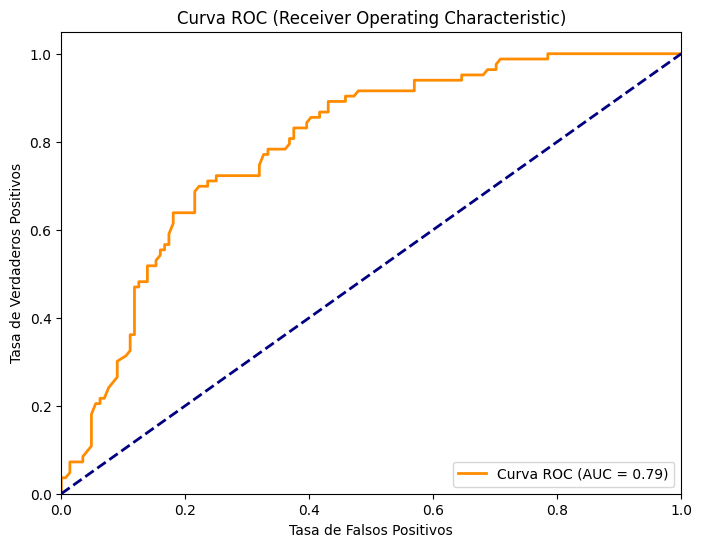

El accuracy score es de: 74.8898678414097%
Matriz de confusión:
[[112  32]
 [ 25  58]]


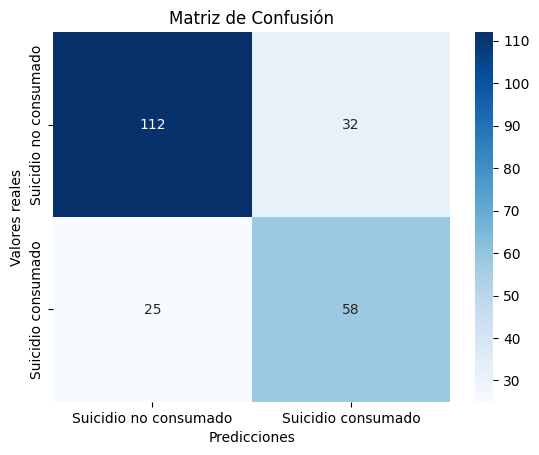

Intercepto: [1.41742109]
Coeficientes:
EDAD: -0.03024390675377288
INTENTOS_PREVIOS_SI: -0.5514939226362008
PSIQUIATRIA_SI: -1.4558096016271422
SEXO_Mujer: -0.584239763313884


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
# Cargar y leer el banco de datos
datos = pd.read_excel('data_ensayo.xlsx')

# Seleccionar las variables de interés
df = datos[['CLASIFICACION_DE_LA_CONDUCTA', 'SEXO', 'EDAD', 'INTENTOS_PREVIOS', 'PSIQUIATRIA']]

# Imputación de datos
df['CONSUMADO'] = np.where(df['CLASIFICACION_DE_LA_CONDUCTA'] == 'Suicidio consumado', 1, 0)
df['PSIQUIATRIA'] = df['PSIQUIATRIA'].replace({'no': 'NO', 'si': 'SI', 'No': 'NO', 'Si': 'SI'})
df['INTENTOS_PREVIOS'] = df['INTENTOS_PREVIOS'].replace({'no': 'NO', 'si': 'SI', 'No': 'NO', 'Si': 'SI'})

# Convertir variables categóricas en variables dummy
df_imputed = pd.get_dummies(df, columns=['SEXO', 'INTENTOS_PREVIOS', 'PSIQUIATRIA'], drop_first=True)

# Dividir el conjunto de datos en entrenamiento y prueba
X = df_imputed[['EDAD', 'INTENTOS_PREVIOS_SI', 'PSIQUIATRIA_SI', 'SEXO_Mujer']]
y = df_imputed['CONSUMADO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir clasificadores a comparar
clasif = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Tree': DecisionTreeClassifier(),
    'LR': LogisticRegression(),
    'Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Evaluar clasificadores con cross-validation
score_matrix = [['SVM', 0, 0],
                ['KNN', 0, 0],
                ['Tree', 0, 0],
                ['LR', 0, 0],
                ['Forest', 0, 0],
                ['XGBoost', 0, 0]]

for i, clf in enumerate(clasif):
    clasificador = clasif[clf]
    scores = cross_val_score(estimator=clasificador, X=X_train, y=y_train, cv=10)
    score_matrix[i][1] = scores.mean()
    score_matrix[i][2] = scores.std()

score_matrix_df = pd.DataFrame(score_matrix, columns=['Modelo', 'Mean Accuracy', 'Std Accuracy'])
print(score_matrix_df)

# Definir los parámetros a buscar
parametros = [{'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.25, 0.5, 0.75, 1, 10, 100]},
              {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.25, 0.5, 0.75, 1, 10, 100]}]

# Inicializar GridSearchCV con 10-fold cross-validation
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=parametros, scoring='accuracy', cv=StratifiedKFold(n_splits=5), n_jobs=-1)

# Ajustar GridSearchCV con datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores resultados
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_
print('Mejor accuracy:', best_accuracy)
print('Mejores parámetros:', best_params)

# Obtener el mejor clasificador
mejor_clasificador = grid_search.best_estimator_

# Entrenar el mejor modelo con los datos de entrenamiento
mejor_clasificador.fit(X_train, y_train)

# Realizar predicciones con los datos de prueba
predicciones_prob = mejor_clasificador.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, predicciones_prob)
roc_auc = auc(fpr, tpr)

# Encontrar el umbral óptimo
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'El umbral óptimo es: {optimal_threshold}')

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

# Clasificar las predicciones basadas en el umbral óptimo
predicciones_optimal = np.where(predicciones_prob >= optimal_threshold, 1, 0)

# Calcular el accuracy score y la matriz de confusión
ac = accuracy_score(y_test, predicciones_optimal)
cm = confusion_matrix(y_test, predicciones_optimal)
print(f'El accuracy score es de: {100*ac}%')
print(f'Matriz de confusión:\n{cm}')

# Graficar la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Suicidio no consumado", "Suicidio consumado"], yticklabels=["Suicidio no consumado", "Suicidio consumado"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

# Obtener los coeficientes del modelo
coeficientes = mejor_clasificador.coef_.flatten()
intercepto = mejor_clasificador.intercept_

# Mostrar los coeficientes y el intercepto
print("Intercepto:", intercepto)
print("Coeficientes:")
for nombre_feature, coef in zip(X.columns, coeficientes):
    print(f"{nombre_feature}: {coef}")
